In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os


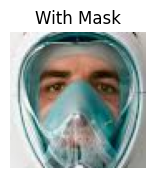

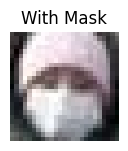

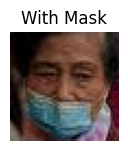

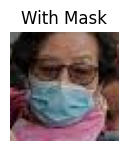

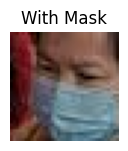

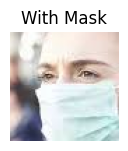

In [6]:
from os import listdir
listdir()
withmask='FaceMask/Face Mask Dataset/Train/WithMask'
train_images_NC=listdir(withmask)
plt.figure(figsize=(6,6))
for i in range(6):
 plt.subplot(3,3,i+1)
 plt.imshow(plt.imread(os.path.join(withmask,train_images_NC[i])),cmap='gray')
 plt.title('With Mask')
 plt.axis('off')
 plt.show()

In [7]:
from os import listdir
listdir()
withoutmask='FaceMask/Face Mask Dataset/Train/WithoutMask'
train_images_NC=listdir(withoutmask)
plt.figure(figsize=(6,6))
for i in range(6):
 plt.subplot(3,3,i+1)
 plt.imshow(plt.imread(os.path.join(withoutmask,train_images_NC[i])),cmap='gray')
 plt.title('Without Mask')
 plt.axis('off')
plt.show()

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'archive/Face Mask Dataset/Train/WithoutMask'